# **FINAL PROJECT - CAEDEN**

In [1]:
## helpful packages
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import random
import re
import string

## Install relevant packages if you haven't already
## ! conda activate qss20
## ! conda install nltk spacy vaderSentiment gensim scikit-learn "scipy<1.13"

## nltk imports
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

## spacy imports
import spacy
### uncomment and run the below line if you haven't loaded the en_core_web_sm library yet
## ! python -m spacy download en_core_web_sm
import en_core_web_sm
nlp = en_core_web_sm.load()

## vectorizer
from sklearn.feature_extraction.text import CountVectorizer

## sentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## LDA
from gensim import corpora
import gensim

## repeated printouts and wide-format text
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_colwidth', None)

## **TWEETS**

In [2]:
## The Climate Change Twitter Dataset
## insert link

tweets = pd.read_csv("The Climate Change Twitter Dataset.csv") 

# Preview
tweets.head()
tweets.tail(10)

# Check column info
tweets.info()

# Missing data
tweets.isnull().sum() ## 7309504 missing values 


,created_at,id,lng,lat,topic,sentiment,stance,gender,temperature_avg,aggressiveness
0,2006-06-06 16:06:42+00:00,6132,NaN,NaN,Weather Extremes,-0.097180,neutral,female,NaN,aggressive
1,2006-07-23 21:52:30+00:00,13275,-73.949582,40.650104,Weather Extremes,0.575777,neutral,undefined,-1.114768,aggressive
2,2006-08-29 01:52:30+00:00,23160,NaN,NaN,Weather Extremes,0.500479,neutral,male,NaN,aggressive
3,2006-11-07 02:46:52+00:00,57868,NaN,NaN,Weather Extremes,0.032816,neutral,male,NaN,aggressive
4,2006-11-27 14:27:43+00:00,304553,NaN,NaN,Importance of Human Intervantion,-0.090428,neutral,male,NaN,aggressive


,created_at,id,lng,lat,topic,sentiment,stance,gender,temperature_avg,aggressiveness
11012363,2018-09-02 08:02:48+00:00,1036162510611730432,NaN,NaN,Undefined / One Word Hashtags,-0.112085,believer,male,NaN,not aggressive
11012364,2018-09-02 08:02:52+00:00,1036162527078633473,NaN,NaN,Global stance,0.107227,believer,male,NaN,aggressive
11012365,2018-09-02 08:02:58+00:00,1036162552127008768,NaN,NaN,Importance of Human Intervantion,0.634885,believer,female,NaN,not aggressive
11012366,2018-09-02 08:03:17+00:00,1036162635606241285,13.410530,52.524370,Undefined / One Word Hashtags,-0.393662,believer,female,8.326254,not aggressive
11012367,2018-09-02 08:03:19+00:00,1036162643751567360,-0.243930,51.451650,Weather Extremes,0.514416,believer,male,4.063849,not aggressive
11012368,2018-09-02 08:03:21+00:00,1036162652400173056,NaN,NaN,Weather Extremes,-0.509263,believer,female,NaN,not aggressive
11012369,2018-09-02 08:03:28+00:00,1036162678253932544,NaN,NaN,Global stance,-0.522887,believer,male,NaN,aggressive
11012370,2018-09-02 08:03:37+00:00,1036162717327998976,NaN,NaN,Undefined / One Word Hashtags,-0.060764,believer,male,NaN,not aggressive
11012371,2018-09-02 08:03:48+00:00,1036162762802642944,32.535650,15.593325,Global stance,0.616264,believer,male,-2.634107,not aggressive
11012372,2018-09-02 08:03:49+00:00,1036162767735218176,-82.669508,27.770380,Global stance,0.140839,neutral,female,0.217859,not


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11012373 entries, 0 to 11012372
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   created_at       object 
 1   id               int64  
 2   lng              float64
 3   lat              float64
 4   topic            object 
 5   sentiment        float64
 6   stance           object 
 7   gender           object 
 8   temperature_avg  float64
 9   aggressiveness   object 
dtypes: float64(4), int64(1), object(5)
memory usage: 840.2+ MB


created_at               0
id                       0
lng                7309504
lat                7309504
topic                    0
sentiment                0
stance                   0
gender                   0
temperature_avg    7309504
aggressiveness           0
dtype: int64

In [3]:
# keep a copy, add in countries later
## tweets_clean = tweets.copy()

# make sure lat/lng are numeric
tweets['lat'] = pd.to_numeric(tweets['lat'], errors='coerce')
tweets['lng'] = pd.to_numeric(tweets['lng'], errors='coerce')

# drop rows with missing coords
tweets = tweets.dropna(subset=['lat', 'lng'])

# keep only realistic coords
tweets = tweets[
    (tweets['lat'] >= -90) & (tweets['lat'] <= 90) &
    (tweets['lng'] >= -180) & (tweets['lng'] <= 180)]


In [4]:
import reverse_geocoder as rg

# build list of (lat, lon) tuples
coords = list(zip(tweets['lat'], tweets['lng']))

# reverse_geocoder can take a list directly
results = rg.search(coords)   # returns list of dicts

Loading formatted geocoded file...


In [6]:
countries = [r['cc'] for r in results]
tweets = tweets.reset_index(drop=True)
tweets['country'] = countries
print(tweets['country']) ## 3702869, but these are abbreviations not the country's name
tweets.info()

0          US
1          US
2          US
3          US
4          GB
           ..
3702864    TR
3702865    DE
3702866    GB
3702867    SD
3702868    US
Name: country, Length: 3702869, dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3702869 entries, 0 to 3702868
Data columns (total 11 columns):
 #   Column           Dtype  
---  ------           -----  
 0   created_at       object 
 1   id               int64  
 2   lng              float64
 3   lat              float64
 4   topic            object 
 5   sentiment        float64
 6   stance           object 
 7   gender           object 
 8   temperature_avg  float64
 9   aggressiveness   object 
 10  country          object 
dtypes: float64(4), int64(1), object(6)
memory usage: 310.8+ MB


In [7]:
## change from abbreviations to country names 

## !pip install pycountry
import pycountry

def country_name_from_code(code):
    try:
        return pycountry.countries.get(alpha_2=code).name
    except:
        return None

# after you already created the 'country' column from reverse_geocoder:
tweets['country_name'] = tweets['country'].apply(country_name_from_code)

tweets[['country', 'country_name']].head()

## tweets_clean['country_name'].drop_duplicates().shape[0] ## 239 countries 
tweets.info()

,country,country_name
0,US,United States
1,US,United States
2,US,United States
3,US,United States
4,GB,United Kingdom


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3702869 entries, 0 to 3702868
Data columns (total 12 columns):
 #   Column           Dtype  
---  ------           -----  
 0   created_at       object 
 1   id               int64  
 2   lng              float64
 3   lat              float64
 4   topic            object 
 5   sentiment        float64
 6   stance           object 
 7   gender           object 
 8   temperature_avg  float64
 9   aggressiveness   object 
 10  country          object 
 11  country_name     object 
dtypes: float64(4), int64(1), object(7)
memory usage: 339.0+ MB


In [10]:
tweets_with_country = tweets[tweets['country_name'].notna()].copy()
tweets_with_country[['lat', 'lng', 'country', 'country_name']].sample(5)
tweets_with_country.info() # 3702827, does this make sense 
coverage = tweets['country_name'].notna().mean() * 100
print(f"{coverage:.1f}% of tweets have valid country information.")

,lat,lng,country,country_name
1975585,51.508530,-0.125740,GB,United Kingdom
1761096,52.131802,-106.660767,CA,Canada
414926,32.222876,-110.974848,US,United States
422337,36.624284,-4.499545,ES,Spain
3035779,39.516223,-76.938207,US,United States


<class 'pandas.core.frame.DataFrame'>
Index: 3702827 entries, 0 to 3702868
Data columns (total 12 columns):
 #   Column           Dtype  
---  ------           -----  
 0   created_at       object 
 1   id               int64  
 2   lng              float64
 3   lat              float64
 4   topic            object 
 5   sentiment        float64
 6   stance           object 
 7   gender           object 
 8   temperature_avg  float64
 9   aggressiveness   object 
 10  country          object 
 11  country_name     object 
dtypes: float64(4), int64(1), object(7)
memory usage: 367.3+ MB
100.0% of tweets have valid country information.


In [54]:
## filter for 2020 to September 2025 (because the other dataset only has this time range)

tweets_with_country['created_at'].head()

tweets_with_country['created_at'] = pd.to_datetime(
    tweets_with_country['created_at'], 
    errors='coerce', 
    utc=True  # keep timezone-safe
)

tweets_with_country['created_at'] ## there's nothing after 2018 

tweets_with_country['year'] = tweets_with_country['created_at'].dt.year
tweets_with_country['year'] ## 2006 to 2018 
tweets_with_country.info()

0   2006-07-23 21:52:30+00:00
1   2006-12-14 01:39:10+00:00
2   2006-12-17 19:43:09+00:00
3   2006-12-21 01:39:01+00:00
4   2006-12-31 10:47:25+00:00
Name: created_at, dtype: datetime64[ns, UTC]

0         2006-07-23 21:52:30+00:00
1         2006-12-14 01:39:10+00:00
2         2006-12-17 19:43:09+00:00
3         2006-12-21 01:39:01+00:00
4         2006-12-31 10:47:25+00:00
                     ...           
3702864   2018-09-02 08:02:39+00:00
3702865   2018-09-02 08:03:17+00:00
3702866   2018-09-02 08:03:19+00:00
3702867   2018-09-02 08:03:48+00:00
3702868   2018-09-02 08:03:49+00:00
Name: created_at, Length: 3702827, dtype: datetime64[ns, UTC]

0          2006
1          2006
2          2006
3          2006
4          2006
           ... 
3702864    2018
3702865    2018
3702866    2018
3702867    2018
3702868    2018
Name: year, Length: 3702827, dtype: int32

<class 'pandas.core.frame.DataFrame'>
Index: 3702827 entries, 0 to 3702868
Data columns (total 13 columns):
 #   Column           Dtype              
---  ------           -----              
 0   created_at       datetime64[ns, UTC]
 1   id               int64              
 2   lng              float64            
 3   lat              float64            
 4   topic            object             
 5   sentiment        float64            
 6   stance           object             
 7   gender           object             
 8   temperature_avg  float64            
 9   aggressiveness   object             
 10  country          object             
 11  country_name     object             
 12  year             int32              
dtypes: datetime64[ns, UTC](1), float64(4), int32(1), int64(1), object(6)
memory usage: 381.4+ MB


In [12]:
## filter for dates - get only certain years



## **DISASTERS**

In [30]:
disasters = pd.read_csv("disasters.csv")  # replace filename
disasters.head() 
disasters.info() ## 4913 rows, 17 columns 

,Disaster Type,Disaster Subtype,Disaster Group,Disaster Subgroup,Event Name,Origin,Country,Location,Latitude,Longitude,start_date,end_date,Total Deaths,No Affected,Reconstruction Costs ('000 US$),Total Damages ('000 US$),CPI
0,Earthquake,Ground movement,Natural,Geophysical,NaN,NaN,Japan,"Nanao, Wajima districts (Isikawa province), Niigata, Toyama provinces",37.336,136.588,2007-03-25,2007-03-25,1.0,NaN,NaN,250000.0,81.101659
1,Storm,Tropical cyclone,Natural,Meteorological,Indhala,NaN,Madagascar,"Diana, Sava, Sofia, Analanjirofo provinces",-14.840,49.940,2007-03-15,2007-03-17,80.0,203182.0,NaN,240000.0,81.101659
2,Flood,Flash flood,Natural,Hydrological,NaN,Storms and heavy rains,Australia,"Gosford, Dungog, Newcastle, Wyong, Port Stephens, Maitland, Cessnock districts (New South Wales province)",-32.870,151.380,2007-06-08,2007-06-12,9.0,5000.0,NaN,1300000.0,81.101659
3,Flood,Riverine flood,Natural,Hydrological,NaN,Heavy rains,Haiti,"Ferrier village (Fort Liberte district, Nord Est province), Ouanaminthe district (Nord Est province), Abricot village (Jeremie district, Grande Anse province)",19.410,-71.780,2007-03-26,2007-03-30,14.0,15000.0,NaN,NaN,81.101659
4,Flood,Riverine flood,Natural,Hydrological,NaN,Heavy rains,Argentina,"Tucuman, Santiago del Estero, Salta, Formosa provinces",NaN,NaN,2007-01-18,2007-03-20,5.0,60000.0,NaN,30000.0,81.101659


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4913 entries, 0 to 4912
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Disaster Type                    4913 non-null   object 
 1   Disaster Subtype                 4212 non-null   object 
 2   Disaster Group                   4913 non-null   object 
 3   Disaster Subgroup                4913 non-null   object 
 4   Event Name                       979 non-null    object 
 5   Origin                           2067 non-null   object 
 6   Country                          4913 non-null   object 
 7   Location                         4787 non-null   object 
 8   Latitude                         1290 non-null   float64
 9   Longitude                        1294 non-null   float64
 10  start_date                       4913 non-null   object 
 11  end_date                         4913 non-null   object 
 12  Total Deaths        

In [31]:
## disasters['Country'].drop_duplicates().shape[0] ## 51 countries - use inner join (both countries) 

In [34]:
disasters['start_date'] = pd.to_datetime(disasters['start_date'], errors='coerce')
disasters['end_date'] = pd.to_datetime(disasters['end_date'], errors='coerce')

## Extract the year from start_date (main time variable)
disasters['year'] = disasters['start_date'].dt.year

disasters['year'] ## 2007 to 2020 

0       2007
1       2007
2       2007
3       2007
4       2007
        ... 
4908    2020
4909    2020
4910    2020
4911    2020
4912    2020
Name: year, Length: 4913, dtype: int32

In [37]:
## Clean numeric columns (handle missing values)
disasters['Total Deaths'] = pd.to_numeric(disasters['Total Deaths'], errors='coerce').fillna(0)
disasters['No Affected'] = pd.to_numeric(disasters['No Affected'], errors='coerce').fillna(0)
disasters["Total Damages ('000 US$)"] = pd.to_numeric(
    disasters["Total Damages ('000 US$)"], errors='coerce'
).fillna(0)

## Standardize country names (trim spaces, title case)
disasters['Country'] = disasters['Country'].str.strip()

## Aggregate to country-year level
disaster_agg = (
    disasters
    .groupby(['Country', 'year'])
    .agg(
        total_deaths=('Total Deaths', 'sum'),
        total_affected=('No Affected', 'sum'),
        total_damages_usd=('Total Damages (\'000 US$)', 'sum'),
        n_events=('Disaster Type', 'count'),
        most_common_type=('Disaster Type', lambda x: x.mode()[0] if not x.mode().empty else None)
    )
    .reset_index()
)

print(disaster_agg)

          Country  year  total_deaths  total_affected  total_damages_usd  \
0     Afghanistan  2007         296.0         26755.0                0.0   
1     Afghanistan  2008        1317.0        451502.0                0.0   
2     Afghanistan  2009         101.0         62521.0            20000.0   
3     Afghanistan  2010         350.0         45000.0                0.0   
4     Afghanistan  2011          83.0       1753000.0           142000.0   
...           ...   ...           ...             ...                ...   
1596     Zimbabwe  2014          14.0          2500.0            20000.0   
1597     Zimbabwe  2015          10.0             0.0                0.0   
1598     Zimbabwe  2016          31.0          2000.0                0.0   
1599     Zimbabwe  2017         251.0        100000.0           189000.0   
1600     Zimbabwe  2019         654.0       7170000.0                0.0   

      n_events most_common_type  
0            7            Flood  
1            3     

<Figure size 800x500 with 0 Axes>

Text(0.5, 1.0, 'Global Disaster Damages (2020–2025)')

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Total Damages (in billions USD)')

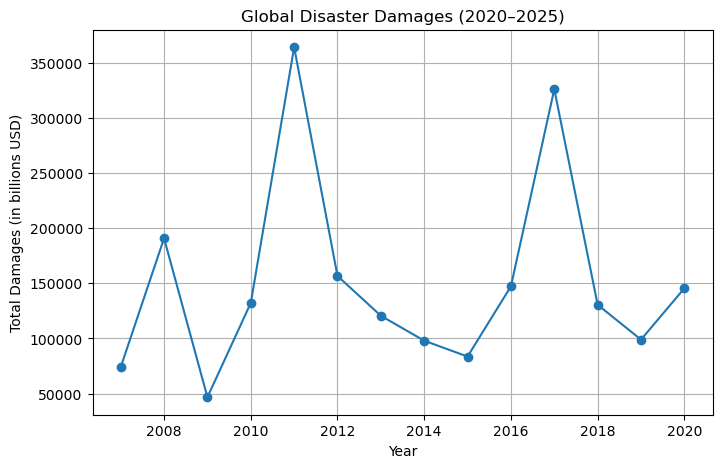

In [38]:
### TOTAL DAMAGES OVER TIME ####


import matplotlib.pyplot as plt

# Group by year across all countries
yearly = (
    disaster_agg.groupby('year')
    .agg(total_damages_usd=('total_damages_usd', 'sum'),
         total_deaths=('total_deaths', 'sum'),
         n_events=('n_events', 'sum'))
    .reset_index()
)

plt.figure(figsize=(8,5))
plt.plot(yearly['year'], yearly['total_damages_usd'] / 1000, marker='o')
plt.title('Global Disaster Damages (2020–2025)')
plt.xlabel('Year')
plt.ylabel('Total Damages (in billions USD)')
plt.grid(True)
plt.show()

<Figure size 900x500 with 0 Axes>

<Axes: xlabel='Country'>

Text(0.5, 1.0, 'Top 10 Countries by People Affected (2020–2025)')

Text(0.5, 0, 'Country')

Text(0, 0.5, 'Total Affected Population')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'China'),
  Text(1, 0, 'India'),
  Text(2, 0, 'Philippines (the)'),
  Text(3, 0, 'United States of America (the)'),
  Text(4, 0, 'Bangladesh'),
  Text(5, 0, 'Thailand'),
  Text(6, 0, 'Pakistan'),
  Text(7, 0, 'Brazil'),
  Text(8, 0, "Korea (the Democratic People's Republic of)"),
  Text(9, 0, 'Ethiopia')])

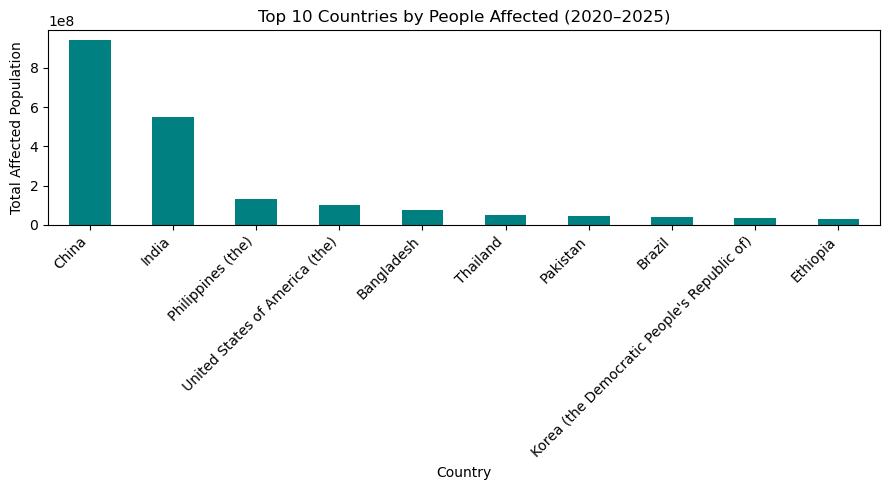

In [39]:
### TOP 10 MOST AFFECTED COUNTRIES ####


top_countries = (
    disaster_agg.groupby('Country')['total_affected']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(9,5))
top_countries.plot(kind='bar', color='teal')
plt.title('Top 10 Countries by People Affected (2020–2025)')
plt.xlabel('Country')
plt.ylabel('Total Affected Population')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Based on our hypothesis, we predict that the greater the damages/deaths/overall severity of natural events were in a given country/year, the more negative the overall sentiment of climate change tweets will be from that year.

# **MERGING**

In [40]:
# --- aggregate sentiment & tweet counts ---
tweet_agg = (
    tweets_with_country
    .groupby(['country_name', 'year'])
    .agg(
        mean_sentiment=('sentiment', 'mean'),
        n_tweets=('id', 'count')
    )
    .reset_index()
)

print("Aggregated tweets shape:", tweet_agg.shape)
print(tweet_agg)

Aggregated tweets shape: (2057, 4)
       country_name  year  mean_sentiment  n_tweets
0       Afghanistan  2010        0.032073         3
1       Afghanistan  2011        0.104726         1
2       Afghanistan  2012        0.174492         2
3       Afghanistan  2013        0.475190         1
4       Afghanistan  2014       -0.054403         5
...             ...   ...             ...       ...
2052       Zimbabwe  2017        0.229554       650
2053       Zimbabwe  2018        0.190220      1035
2054  Åland Islands  2009        0.214765         1
2055  Åland Islands  2015        0.160024         2
2056  Åland Islands  2018        0.406029         1

[2057 rows x 4 columns]


In [41]:
## which countries have the most tweets 

country_counts = tweet_agg.groupby('country_name')['n_tweets'].sum().sort_values(ascending=False)

print(country_counts.head(30))  # top 10 countries with most tweets

country_name
United States     2097940
United Kingdom     358601
Canada             289687
Australia          197581
India               86014
Finland             58921
Germany             44284
France              34312
Indonesia           33109
Italy               28417
South Africa        25746
Spain               24215
Ireland             23715
New Zealand         23479
Pakistan            21416
Netherlands         21199
Kenya               20111
Nigeria             20006
Switzerland         19783
Colombia            18926
Belgium             18500
Sweden              16544
Mexico              13071
Philippines         12657
Brazil              11515
Norway              11312
Puerto Rico          9284
Denmark              6831
Thailand             6663
Bangladesh           6476
Name: n_tweets, dtype: int64


In [42]:
if 'Country' in disaster_agg.columns:
    disaster_agg = disaster_agg.rename(columns={'Country': 'country_name'})

## which countries are in disaster_agg 

print(disaster_agg)

     country_name  year  total_deaths  total_affected  total_damages_usd  \
0     Afghanistan  2007         296.0         26755.0                0.0   
1     Afghanistan  2008        1317.0        451502.0                0.0   
2     Afghanistan  2009         101.0         62521.0            20000.0   
3     Afghanistan  2010         350.0         45000.0                0.0   
4     Afghanistan  2011          83.0       1753000.0           142000.0   
...           ...   ...           ...             ...                ...   
1596     Zimbabwe  2014          14.0          2500.0            20000.0   
1597     Zimbabwe  2015          10.0             0.0                0.0   
1598     Zimbabwe  2016          31.0          2000.0                0.0   
1599     Zimbabwe  2017         251.0        100000.0           189000.0   
1600     Zimbabwe  2019         654.0       7170000.0                0.0   

      n_events most_common_type  
0            7            Flood  
1            3     

In [43]:
## how many unique countries are there?
## and which countries overlap with the countries from the disasters dataset

tweets_countries = set(tweet_agg['country_name'].dropna().unique())
disaster_countries = set(disaster_agg['country_name'].dropna().unique())

print("Tweets countries:", len(tweets_countries))
print("Disaster countries:", len(disaster_countries))

overlap_countries = tweets_countries.intersection(disaster_countries)
print("Countries in both datasets:", len(overlap_countries))
print(sorted(tweets_countries))

Tweets countries: 238
Disaster countries: 203
Countries in both datasets: 164
['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Anguilla', 'Antarctica', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia, Plurinational State of', 'Bonaire, Sint Eustatius and Saba', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Cayman Islands', 'Central African Republic', 'Chad', 'Chile', 'China', 'Cocos (Keeling) Islands', 'Colombia', 'Congo', 'Congo, The Democratic Republic of the', 'Costa Rica', 'Croatia', 'Cuba', 'Curaçao', 'Cyprus', 'Czechia', "Côte d'Ivoire", 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini'

In [44]:
merged = tweet_agg.merge(
    disaster_agg,
    on=['country_name', 'year'],
    how='inner'   # only keep overlapping country-years
)

print("Merged shape:", merged.shape) ## (908, 8)
merged.head()

Merged shape: (908, 9)


,country_name,year,mean_sentiment,n_tweets,total_deaths,total_affected,total_damages_usd,n_events,most_common_type
0,Afghanistan,2010,0.032073,3,350.0,45000.0,0.0,5,Flood
1,Afghanistan,2011,0.104726,1,83.0,1753000.0,142000.0,4,Flood
2,Afghanistan,2012,0.174492,2,378.0,48394.0,0.0,11,Flood
3,Afghanistan,2013,0.475190,1,155.0,21485.0,0.0,6,Flood
4,Afghanistan,2014,-0.054403,5,575.0,140000.0,3000.0,3,Flood


In [45]:
# quick numeric correlation
correlation = merged[['mean_sentiment', 'total_damages_usd', 'total_deaths', 'total_affected', 'n_events']].corr()
print(correlation['mean_sentiment'])
print(merged.shape)

mean_sentiment       1.000000
total_damages_usd   -0.038509
total_deaths        -0.012199
total_affected      -0.042945
n_events            -0.026106
Name: mean_sentiment, dtype: float64
(908, 9)


All correlations are slightly negative, but very weak (close to 0). This means that, in your data, countries experiencing more or larger disasters tend to have slightly lower (more negative) climate sentiment, but the effect is very small.
The lack of strong correlation could come from:
- Non-overlapping time ranges (tweets mostly ≤2018, disasters ≥2020)
- Aggregated averaging — sentiment compressed to one number per country-year loses local variation
- Missing intermediate variables (e.g., media coverage, policy discussions, etc.)
- Limited overlap in countries — fewer matching country_name and year pairs reduce statistical power

In [59]:
# Filter for country-years with at least ___ tweets
filtered_1000 = merged[merged['n_tweets'] >= 1000]

# Compute correlation on the filtered data
correlation2 = filtered_1000[['mean_sentiment', 'total_damages_usd', 'total_deaths', 'total_affected', 'n_events']].corr()

print(correlation2['mean_sentiment'])
print("Filtered shape:", filtered_1000.shape)

mean_sentiment       1.000000
total_damages_usd   -0.221770
total_deaths        -0.026021
total_affected      -0.075686
n_events            -0.034863
Name: mean_sentiment, dtype: float64
Filtered shape: (130, 9)


In [60]:
# Filter for country-years with at least ___ tweets
filtered_5000 = merged[merged['n_tweets'] >= 5000]

# Compute correlation on the filtered data
correlation3 = filtered_5000[['mean_sentiment', 'total_damages_usd', 'total_deaths', 'total_affected', 'n_events']].corr()

print(correlation3['mean_sentiment'])
print("Filtered shape:", filtered_5000.shape)

mean_sentiment       1.000000
total_damages_usd   -0.290383
total_deaths         0.259303
total_affected       0.024937
n_events             0.135264
Name: mean_sentiment, dtype: float64
Filtered shape: (44, 9)


Text(0.5, 1.0, 'Climate Sentiment Over Time by Country')

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Mean Sentiment')

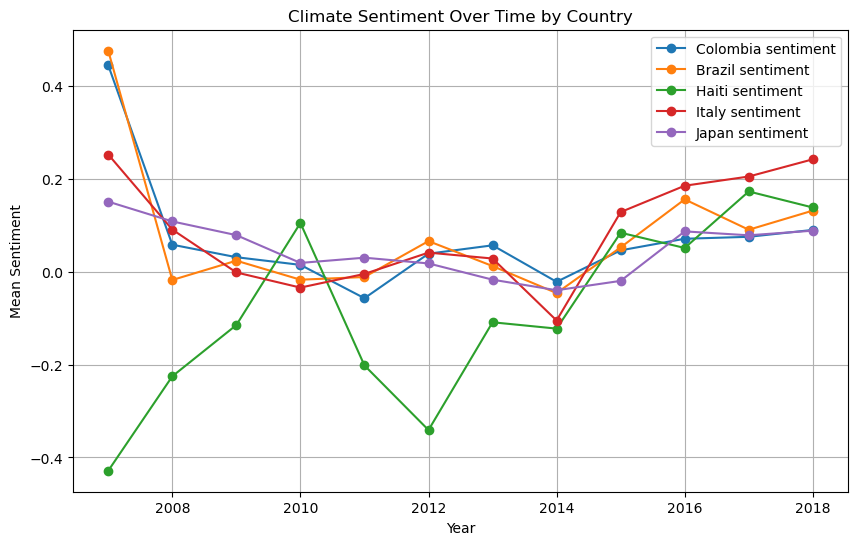

In [47]:
### PLOTTING ### 

countries_to_plot = merged['country_name'].value_counts().head(5).index ## choosing countries that appear most frequently in data

fig, ax1 = plt.subplots(figsize=(10,6))

for country in countries_to_plot:
    subset = merged[merged['country_name'] == country]
    ax1.plot(subset['year'], subset['mean_sentiment'], marker='o', label=f"{country} sentiment")

plt.title('Climate Sentiment Over Time by Country')
plt.xlabel('Year')
plt.ylabel('Mean Sentiment')
plt.legend()
plt.grid(True)
plt.show()


Text(0, 0.5, 'Mean Sentiment')

Text(0, 0.5, 'Total Damages (in Millions USD)')

Text(0.5, 1.0, 'Colombia: Sentiment vs. Disaster Damages Over Time')

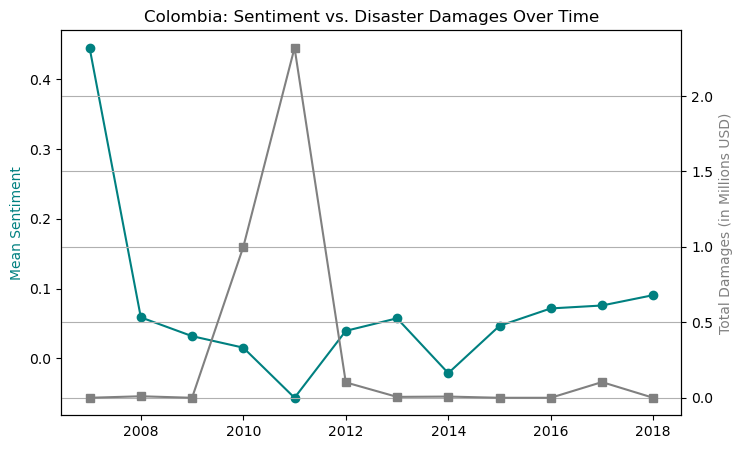

In [61]:
### SENTIMENTS VS DAMAGES ### 

country = 'Colombia'  # change to any country in your data
subset = merged[merged['country_name'] == country]

fig, ax1 = plt.subplots(figsize=(8,5))

ax1.plot(subset['year'], subset['mean_sentiment'], color='teal', marker='o', label='Mean Sentiment')
ax1.set_ylabel('Mean Sentiment', color='teal')

ax2 = ax1.twinx()
ax2.plot(subset['year'], subset['total_damages_usd']/1e6, color='gray', marker='s', label='Total Damages (Millions)')
ax2.set_ylabel('Total Damages (in Millions USD)', color='gray')

plt.title(f"{country}: Sentiment vs. Disaster Damages Over Time")
plt.grid(True)
plt.show()

Text(0, 0.5, 'Mean Sentiment')

Text(0, 0.5, 'Total Damages (in Millions USD)')

Text(0.5, 1.0, 'Brazil: Sentiment vs. Disaster Damages Over Time')

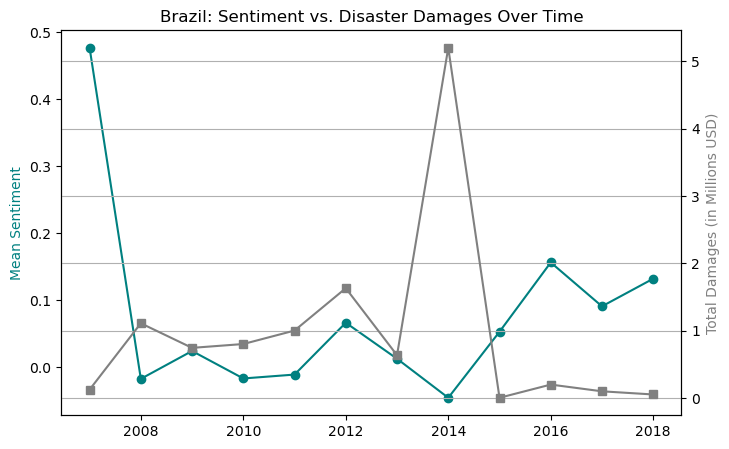

In [62]:
### SENTIMENTS VS DAMAGES ### 

country = 'Brazil'  # change to any country in your data
subset = merged[merged['country_name'] == country]

fig, ax1 = plt.subplots(figsize=(8,5))

ax1.plot(subset['year'], subset['mean_sentiment'], color='teal', marker='o', label='Mean Sentiment')
ax1.set_ylabel('Mean Sentiment', color='teal')

ax2 = ax1.twinx()
ax2.plot(subset['year'], subset['total_damages_usd']/1e6, color='gray', marker='s', label='Total Damages (Millions)')
ax2.set_ylabel('Total Damages (in Millions USD)', color='gray')

plt.title(f"{country}: Sentiment vs. Disaster Damages Over Time")
plt.grid(True)
plt.show()

Text(0, 0.5, 'Mean Sentiment')

Text(0, 0.5, 'Total Damages (in Millions USD)')

Text(0.5, 1.0, 'Haiti: Sentiment vs. Disaster Damages Over Time')

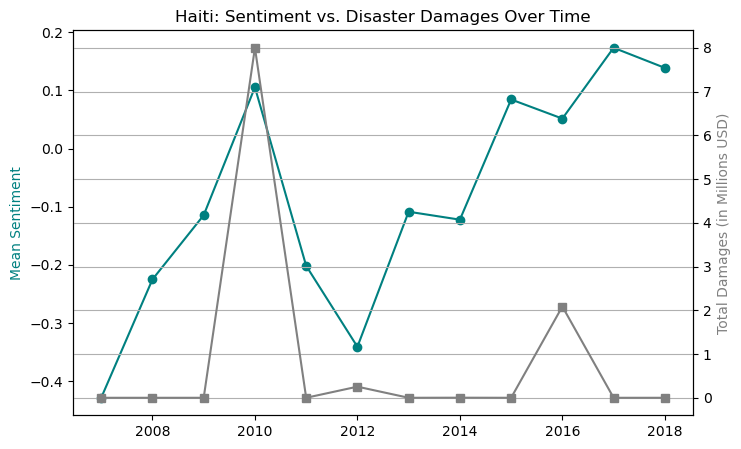

In [63]:
### SENTIMENTS VS DAMAGES ### 

country = 'Haiti'  # change to any country in your data
subset = merged[merged['country_name'] == country]

fig, ax1 = plt.subplots(figsize=(8,5))

ax1.plot(subset['year'], subset['mean_sentiment'], color='teal', marker='o', label='Mean Sentiment')
ax1.set_ylabel('Mean Sentiment', color='teal')

ax2 = ax1.twinx()
ax2.plot(subset['year'], subset['total_damages_usd']/1e6, color='gray', marker='s', label='Total Damages (Millions)')
ax2.set_ylabel('Total Damages (in Millions USD)', color='gray')

plt.title(f"{country}: Sentiment vs. Disaster Damages Over Time")
plt.grid(True)
plt.show()

## doesn't work ??

Text(0, 0.5, 'Mean Sentiment')

Text(0, 0.5, 'Total Damages (in Millions USD)')

Text(0.5, 1.0, 'Italy: Sentiment vs. Disaster Damages Over Time')

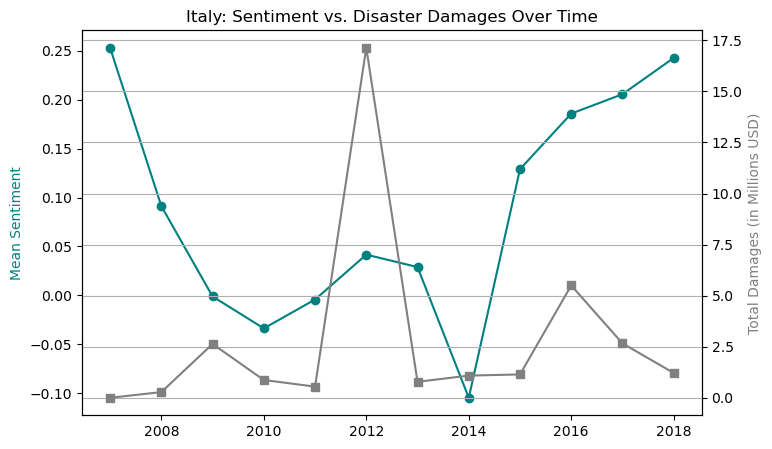

In [64]:
### SENTIMENTS VS DAMAGES ### 

country = 'Italy'  # change to any country in your data
subset = merged[merged['country_name'] == country]

fig, ax1 = plt.subplots(figsize=(8,5))

ax1.plot(subset['year'], subset['mean_sentiment'], color='teal', marker='o', label='Mean Sentiment')
ax1.set_ylabel('Mean Sentiment', color='teal')

ax2 = ax1.twinx()
ax2.plot(subset['year'], subset['total_damages_usd']/1e6, color='gray', marker='s', label='Total Damages (Millions)')
ax2.set_ylabel('Total Damages (in Millions USD)', color='gray')

plt.title(f"{country}: Sentiment vs. Disaster Damages Over Time")
plt.grid(True)
plt.show()

## doesn't work ??

Text(0, 0.5, 'Mean Sentiment')

Text(0, 0.5, 'Total Damages (in Millions USD)')

Text(0.5, 1.0, 'Japan: Sentiment vs. Disaster Damages Over Time')

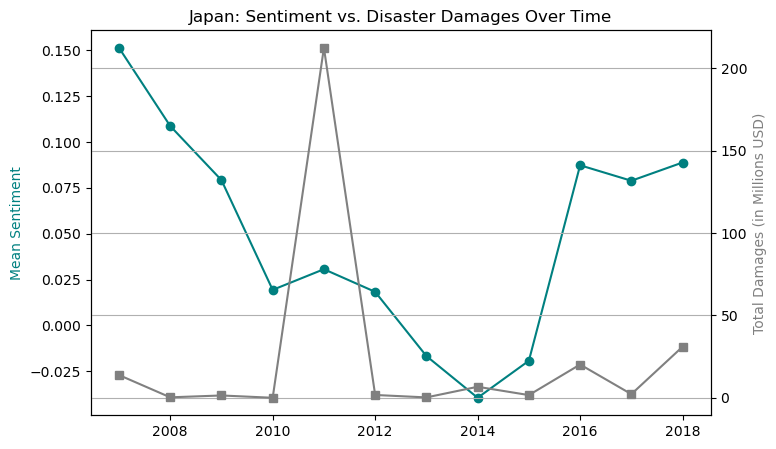

In [65]:
### SENTIMENTS VS DAMAGES ### 

country = 'Japan'  # change to any country in your data
subset = merged[merged['country_name'] == country]

fig, ax1 = plt.subplots(figsize=(8,5))

ax1.plot(subset['year'], subset['mean_sentiment'], color='teal', marker='o', label='Mean Sentiment')
ax1.set_ylabel('Mean Sentiment', color='teal')

ax2 = ax1.twinx()
ax2.plot(subset['year'], subset['total_damages_usd']/1e6, color='gray', marker='s', label='Total Damages (Millions)')
ax2.set_ylabel('Total Damages (in Millions USD)', color='gray')

plt.title(f"{country}: Sentiment vs. Disaster Damages Over Time")
plt.grid(True)
plt.show()

## doesn't work ??

,country_name,mean_sentiment,total_damages_usd,total_deaths,total_affected,n_events
0,Afghanistan,0.126091,148000.0,2420.0,15550749.0,51
1,Albania,0.086407,8900.0,15.0,319200.0,11
2,Algeria,0.154914,0.0,72.0,160200.0,7
3,Angola,0.182043,2000.0,371.0,1659703.0,18
4,Anguilla,0.168154,200000.0,4.0,15000.0,1


mean_sentiment       1.000000
total_damages_usd   -0.038126
total_deaths        -0.076435
total_affected      -0.030650
n_events             0.002364
Name: mean_sentiment, dtype: float64


<Axes: xlabel='total_damages_usd', ylabel='mean_sentiment'>

Text(0.5, 1.0, 'Mean Sentiment vs. Total Damages Usd')

<Axes: xlabel='total_deaths', ylabel='mean_sentiment'>

Text(0.5, 1.0, 'Mean Sentiment vs. Total Deaths')

<Axes: xlabel='total_affected', ylabel='mean_sentiment'>

Text(0.5, 1.0, 'Mean Sentiment vs. Total Affected')

<Axes: xlabel='n_events', ylabel='mean_sentiment'>

Text(0.5, 1.0, 'Mean Sentiment vs. N Events')

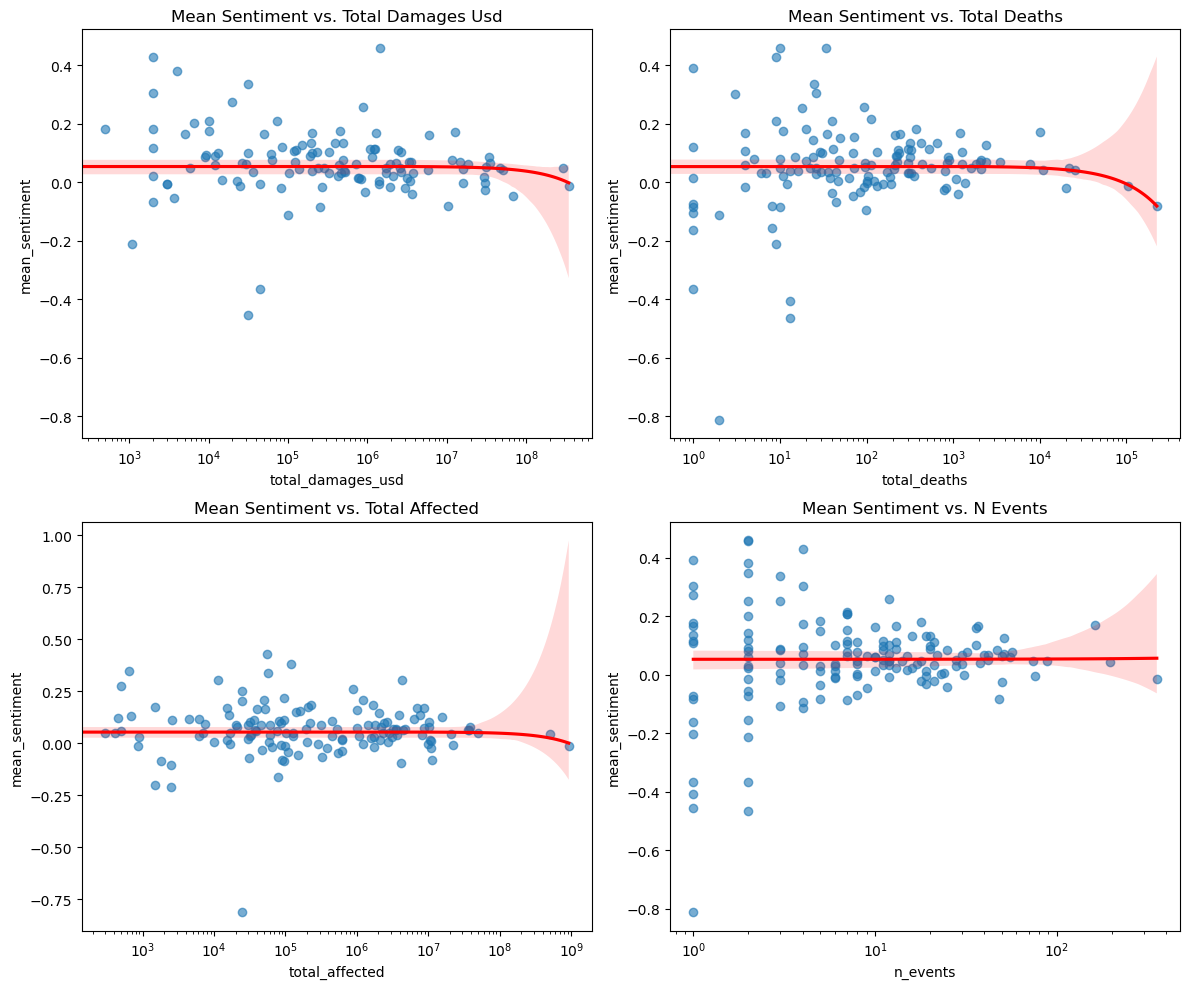

In [66]:
import seaborn as sns

country_merge = (
    merged
    .groupby('country_name', as_index=False)
    .agg(
        mean_sentiment=('mean_sentiment', 'mean'),
        total_damages_usd=('total_damages_usd', 'sum'),
        total_deaths=('total_deaths', 'sum'),
        total_affected=('total_affected', 'sum'),
        n_events=('n_events', 'sum')
    )
)
country_merge.head()

corrs = country_merge[['mean_sentiment', 'total_damages_usd', 'total_deaths', 'total_affected', 'n_events']].corr()
print(corrs['mean_sentiment'])

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

metrics = ['total_damages_usd', 'total_deaths', 'total_affected', 'n_events']

for i, m in enumerate(metrics):
    sns.regplot(data=country_merge, x=m, y='mean_sentiment', ax=axes[i],
                scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
    axes[i].set_xscale('log')
    axes[i].set_title(f'Mean Sentiment vs. {m.replace("_", " ").title()}')

plt.tight_layout()
plt.show()

,mean_sentiment,severity_index
mean_sentiment,1.000000,-0.041148
severity_index,-0.041148,1.000000


<Figure size 800x600 with 0 Axes>

<Axes: xlabel='severity_index', ylabel='mean_sentiment'>

Text(0.5, 1.0, 'Correlation Between Combined Disaster Severity and Mean Sentiment by Country')

Text(0.5, 0, 'Combined Disaster Severity Index')

Text(0, 0.5, 'Mean Sentiment')

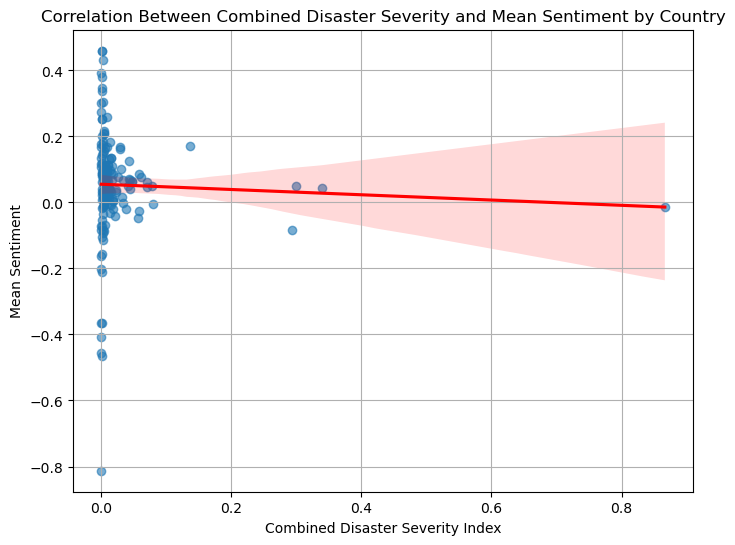

In [53]:
### CREATE A COMBINED SEVERITY INDEX ### 

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
country_merge[['damages_norm', 'deaths_norm', 'affected_norm', 'events_norm']] = scaler.fit_transform(
    country_merge[['total_damages_usd', 'total_deaths', 'total_affected', 'n_events']]
)

# combined severity = average of normalized scores
country_merge['severity_index'] = country_merge[['damages_norm', 'deaths_norm', 'affected_norm', 'events_norm']].mean(axis=1)

country_merge[['mean_sentiment', 'severity_index']].corr()

plt.figure(figsize=(8,6))
sns.regplot(data=country_merge, x='severity_index', y='mean_sentiment',
            scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.title('Correlation Between Combined Disaster Severity and Mean Sentiment by Country')
plt.xlabel('Combined Disaster Severity Index')
plt.ylabel('Mean Sentiment')
plt.grid(True)
plt.show()
